In [82]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
if os.getcwd().split('/')[-1] != "vegetation_health":
    os.chdir('..')
    
assert os.getcwd().split('/')[-1] == "vegetation_health", f"Working directory should be the root (), currently: {os.getcwd()}"

from predictor.analysis.plot_results import plot_results
from predictor.analysis.utils import load_model_data
from postprocessing.eng_utils import create_dataset_from_vars, drop_nans_and_flatten
from predictor.preprocessing import KEY_COLS, VALUE_COLS, VEGETATION_LABELS

# pip install git+https://github.com/amueller/dabl.git
import dabl

# Read in the data

In [27]:
data_dir = Path('/Volumes/Lees_Extend/data/vegetation_health_data')
processed_data=Path('/Volumes/Lees_Extend/data/vegetation_health_data/processed')
models_parent_dir = Path("/Volumes/Lees_Extend/data/vegetation_health_data/")

normalising_dict_path = data_dir / "processed" / "normalizing_dict.json"
train_dir=Path("/Volumes/Lees_Extend/data/vegetation_health_data/processed/ndvi_anomaly/arrays/train")
test_dir=Path("/Volumes/Lees_Extend/data/vegetation_health_data/processed/ndvi_anomaly/arrays/test")
lin_predictions_path = models_parent_dir / "linear" / "preds.npy"
ff_predictions_path = models_parent_dir / "feedforward" / "preds.npy"
rec_predictions_path = models_parent_dir / "recurrent" / "preds.npy"

In [28]:
# read the predictions
lin_preds = np.load(lin_predictions_path)
ff_preds = np.load(ff_predictions_path)
rec_preds = np.load(rec_predictions_path)
true = np.load(processed_data / "ndvi_anomaly" / 'arrays/test/y.npy')

True

In [29]:
def load_model_data(train_or_test, target='ndvi', train_dir='', test_dir=''):
    """ Return a named tuple with the following data attrs
    x, y, latlon, years. This is the data fed through the model.

    Example:
    -------
    >>> train_data = load_model_data("train")
    >>> test_data = load_model_data("test")
    """
    if train_or_test == "test":
        if test_dir == "":
            data_dir = Path('.') / "data" / "processed" /  target  / "arrays" / "test"
        else:
            data_dir = Path(test_dir)
    elif train_or_test == "train":
        if train_dir == "":
            data_dir = Path('.') / "data" / "processed" /  target  / "arrays" / "train"
        else:
            data_dir = Path(train_dir)
    else:
        assert False, "train_or_test must be either ['train','test']"

    Data = namedtuple('Data',["x","y","latlon","years"])
    data = Data(
        x=np.load(data_dir/"x.npy"),
        y=np.load(data_dir/"y.npy"),
        latlon=np.load(data_dir/"latlon.npy"),
        years=np.load(data_dir/"years.npy"),
    )

    return data

In [34]:
# read in data that is fed through the models (train/test)
train_data = load_model_data("train", target="ndvi_anomaly", train_dir=train_dir)
test_data = load_model_data("test", target="ndvi_anomaly", test_dir=test_dir)

In [43]:
len(train_data.latlon)

14587

In [44]:
# create a xr.Dataset object
lin_preds_xr = create_dataset_from_vars(lin_preds, test_data.latlon, "lin_preds", to_xarray=True)
ff_preds_xr = create_dataset_from_vars(ff_preds, test_data.latlon, "ff_preds", to_xarray=True)
rec_preds_xr = create_dataset_from_vars(rec_preds, test_data.latlon, "rec_preds", to_xarray=True)
true_xr = create_dataset_from_vars(true, test_data.latlon, "true", to_xarray=True)

ds = lin_preds_xr.merge(true_xr)
ds = ds.merge(ff_preds_xr)
ds = ds.merge(rec_preds_xr)
ds

<xarray.Dataset>
Dimensions:    (lat: 11, lon: 118)
Coordinates:
  * lat        (lat) float64 -4.975 -4.925 -4.875 ... -4.575 -4.525 -4.475
  * lon        (lon) float64 32.62 32.68 32.72 32.77 ... 39.07 39.12 39.18 39.22
Data variables:
    lin_preds  (lat, lon) float64 0.05231 0.0484 0.04381 0.05253 ... nan nan nan
    true       (lat, lon) float64 0.04739 0.01285 0.01138 ... nan nan nan
    ff_preds   (lat, lon) float32 0.030847011 0.021692704 ... nan nan
    rec_preds  (lat, lon) float32 0.024804994 0.01557853 0.008695264 ... nan nan

In [48]:
difference_lin = ds.true - ds.lin_preds
difference_ff = ds.true - ds.ff_preds
difference_rec = ds.true - ds.rec_preds

da = xr.DataArray(difference_lin, coords=[ds.lat, ds.lon], dims=['lat','lon'])
diff = da.to_dataset(name='difference_lin')
ds = ds.merge(diff)

da = xr.DataArray(difference_ff, coords=[ds.lat, ds.lon], dims=['lat','lon'])
diff = da.to_dataset(name='difference_ff')
ds = ds.merge(diff)

da = xr.DataArray(difference_rec, coords=[ds.lat, ds.lon], dims=['lat','lon'])
diff = da.to_dataset(name='difference_rec')
ds = ds.merge(diff)

In [49]:
ds

<xarray.Dataset>
Dimensions:         (lat: 11, lon: 118)
Coordinates:
  * lat             (lat) float64 -4.975 -4.925 -4.875 ... -4.575 -4.525 -4.475
  * lon             (lon) float64 32.62 32.68 32.72 32.77 ... 39.12 39.18 39.22
Data variables:
    lin_preds       (lat, lon) float64 0.05231 0.0484 0.04381 ... nan nan nan
    true            (lat, lon) float64 0.04739 0.01285 0.01138 ... nan nan nan
    ff_preds        (lat, lon) float32 0.030847011 0.021692704 ... nan nan
    rec_preds       (lat, lon) float32 0.024804994 0.01557853 ... nan nan
    difference_lin  (lat, lon) float64 -0.004922 -0.03555 -0.03243 ... nan nan
    difference_ff   (lat, lon) float64 0.01654 -0.008843 -0.007591 ... nan nan
    difference_rec  (lat, lon) float64 0.02258 -0.002729 0.00268 ... nan nan nan

# What are we training on?

In [58]:
print(VALUE_COLS)
test_data.x.shape

['lst_night', 'lst_day', 'precip', 'sm', 'ndvi', 'evi', 'ndvi_anomaly']


(1139, 11, 7)

In [185]:
def create_dataframe(X, drop_veg=False):
    """Create a dataframe from the numpy arrays in X"""
    assert X.shape[-1] == 7, f"Currently only working with the data defined in VALUE_COLS: {VALUE_COLS}. Current shape: {X.shape}"

    # create dataframe headers
    cols = [f"{col}_{int(ix/7)+1}" for ix,col in enumerate(np.tile(VALUE_COLS,11))]
    # create dataframe from the data
    dim1=X.shape[0]
    dim2=X.shape[1] * X.shape[2]
    df = pd.DataFrame(X.reshape(dim1, dim2), columns=cols)
    if drop_veg:
        df = df.drop(columns=[col for col in df.columns if any(i in col for i in ['ndvi','evi'])])
    return df

df = create_dataframe(train_data.x)
df['target'] = train_data.y
df = df.drop(columns=[col for col in df.columns if any(i in col for i in ['ndvi','evi'])])
df.head()

,lst_night_1,lst_day_1,precip_1,sm_1,lst_night_2,lst_day_2,precip_2,sm_2,lst_night_3,lst_day_3,...,sm_9,lst_night_10,lst_day_10,precip_10,sm_10,lst_night_11,lst_day_11,precip_11,sm_11,target
0,-0.938023,-0.917472,-0.754253,0.169820,-0.566781,-0.188541,-0.752405,-1.113726,-0.333675,0.415154,...,0.607730,-0.363892,-1.521168,2.099906,1.385575,-0.670383,-1.428045,0.380899,1.412591,0.039288
1,-0.873271,-0.959217,-0.754240,-0.482539,-0.579731,-0.532134,-0.749456,-0.784559,-0.044452,0.440843,...,0.053406,-0.389793,-1.556491,2.678044,-0.965251,-0.838737,-1.241798,-0.319449,0.846290,0.045987
2,-0.938023,-0.779393,-0.754241,0.053406,-0.821470,-0.175697,-0.752475,-0.887285,-0.018551,0.344509,...,1.292074,-0.575414,-1.232165,1.781216,0.935919,-0.562464,-0.943161,-0.637153,-0.587644,-0.078612
3,-0.860321,-0.477545,-0.754241,-0.887285,-0.420011,-0.027984,-0.752418,-0.965251,-0.294824,0.293131,...,1.292074,-0.299141,-1.347766,1.196811,1.115176,-0.765352,-1.373455,0.412220,1.292074,-0.009313
4,-0.782619,-0.811504,-0.754241,-0.348903,-0.506346,-0.272031,-0.752442,-0.965251,-0.057402,0.444055,...,1.948635,-0.359576,-1.684936,2.731635,0.935919,-0.691967,-1.591813,0.672023,1.292074,0.080988


# Exploratory Data Analysis

Target looks like regression
Showing only top 10 of 44 continuous features


/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/dabl/plot/utils.py:543: UserWarning: Dropped 4 outliers in column precip_4.
  int(dropped), series.name), UserWarning)
/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/dabl/plot/utils.py:543: UserWarning: Dropped 16 outliers in column precip_11.
  int(dropped), series.name), UserWarning)


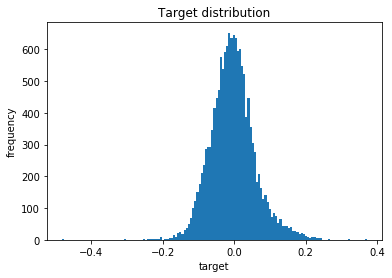

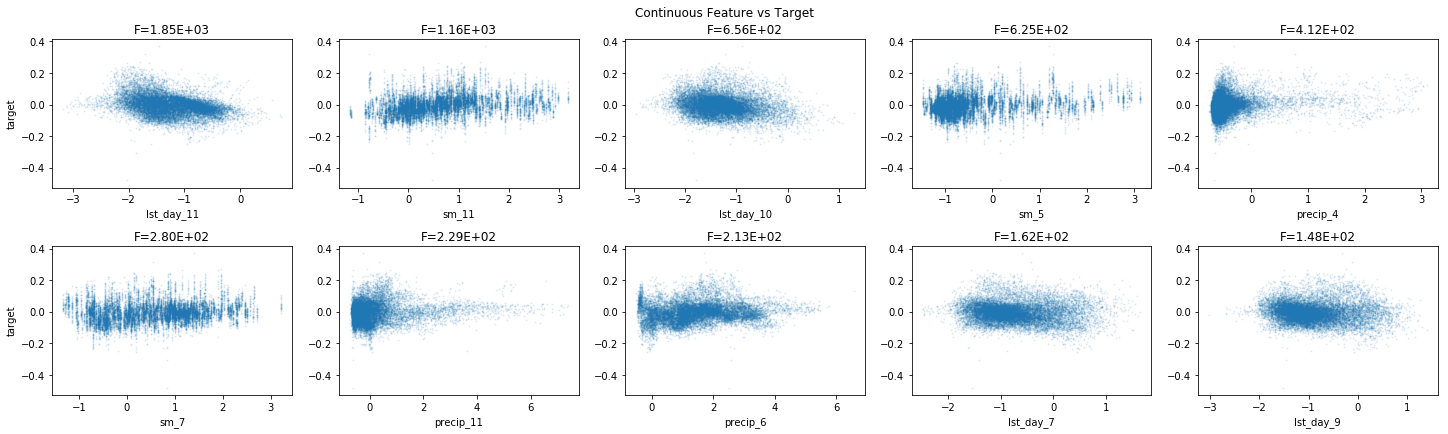

In [135]:
dabl.plot_supervised(df, target_col="target")
plt.show()

# Fit linear models

DummyRegressor()
neg_mean_squared_error: -0.004    r2: -0.000    
new best (using r2):
neg_mean_squared_error   -3.848e-03
r2                       -1.470e-04
Name: DummyRegressor(), dtype: float64
DecisionTreeRegressor(max_depth=1)
neg_mean_squared_error: -0.003    r2: 0.090    
new best (using r2):
neg_mean_squared_error   -0.003
r2                        0.090
Name: DecisionTreeRegressor(max_depth=1), dtype: float64
DecisionTreeRegressor(max_depth=5)
neg_mean_squared_error: -0.003    r2: 0.339    
new best (using r2):
neg_mean_squared_error   -0.003
r2                        0.339
Name: DecisionTreeRegressor(max_depth=5), dtype: float64
Ridge(alpha=10)
neg_mean_squared_error: -0.002    r2: 0.407    
new best (using r2):
neg_mean_squared_error   -0.002
r2                        0.407
Name: Ridge(alpha=10), dtype: float64
Lasso(alpha=10)
neg_mean_squared_error: -0.004    r2: -0.000    
Best model:
Ridge(alpha=10)
Best Scores:
neg_mean_squared_error   -0.002
r2                        0

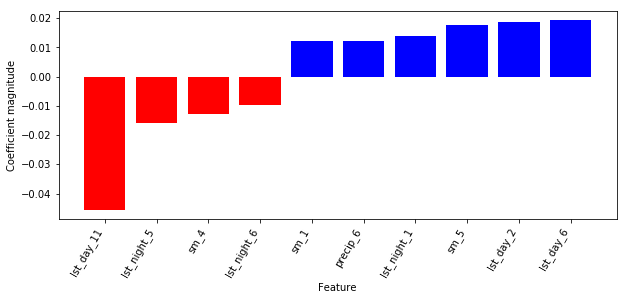

In [140]:
er = dabl.SimpleRegressor(random_state=0).fit(df, target_col="target")
dabl.explain(er)

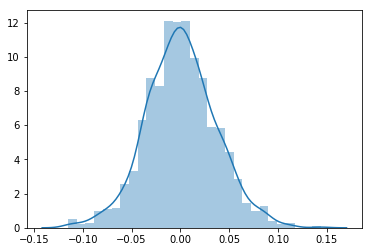

In [190]:
ridge_pipeline = er.est_
test_df = create_dataframe(test_data.x, drop_veg=True)

linear_preds = ridge_pipeline.predict(test_df)
linear_true = test_data.y

diff = linear_true - linear_preds
sns.distplot(diff)

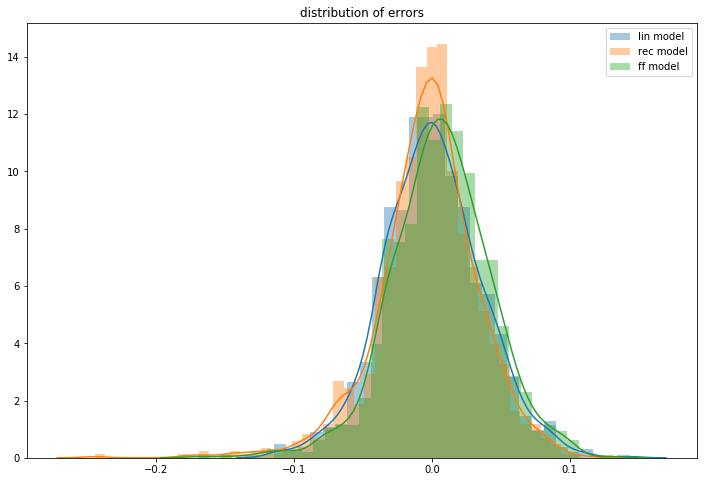

In [192]:
fig,ax=plt.subplots(figsize=(12,8))
for model in ['lin','rec','ff']:
    sns.distplot(drop_nans_and_flatten(ds[f'difference_{model}']),label=f'{model} model',ax=ax)

# sns.distplot(diff,label=f'RidgeRegression model')
ax.set_title("distribution of errors")
plt.legend()

# Explore the linear model coefficients

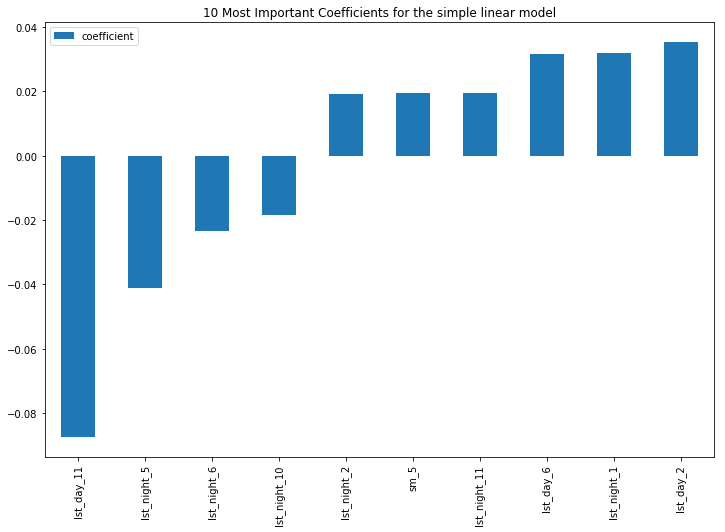

In [154]:
# from sklearn import linear_model
# linear_model.LinearRegression()

linear_model = np.load(models_parent_dir / "linear" / 'model.npy')
linear_model.shape
coefs = pd.DataFrame(dict(zip(df.drop(columns='target').columns, linear_model)), index=[0]).T.rename(columns={0:'coefficient'})

fig,ax = plt.subplots(figsize=(12,8))
ax.set_title('10 Most Important Coefficients for the simple linear model')
largest_10 = coefs.apply(abs).nlargest(10,'coefficient').index
coefs.loc[largest_10].sort_values(by='coefficient').plot.bar(ax=ax)

In [103]:
ds

<xarray.Dataset>
Dimensions:         (lat: 11, lon: 118)
Coordinates:
  * lat             (lat) float64 -4.975 -4.925 -4.875 ... -4.575 -4.525 -4.475
  * lon             (lon) float64 32.62 32.68 32.72 32.77 ... 39.12 39.18 39.22
Data variables:
    lin_preds       (lat, lon) float64 0.05231 0.0484 0.04381 ... nan nan nan
    true            (lat, lon) float64 0.04739 0.01285 0.01138 ... nan nan nan
    ff_preds        (lat, lon) float32 0.030847011 0.021692704 ... nan nan
    rec_preds       (lat, lon) float32 0.024804994 0.01557853 ... nan nan
    difference_lin  (lat, lon) float64 -0.004922 -0.03555 -0.03243 ... nan nan
    difference_ff   (lat, lon) float64 0.01654 -0.008843 -0.007591 ... nan nan
    difference_rec  (lat, lon) float64 0.02258 -0.002729 0.00268 ... nan nan nan